### Predictive Modeling
In this notebook, we explore various models to predict crime type based on various time and location predictors. 

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
def multi_performance(y_true, y_pred, classes, y_score=None):
    """
    Returns a dataframe that summarizes performance metrics (accuracy, f1, precision, recall)
    for each class and the overall score (which returns a weighted average of all the scores 
    based on the number of true instances)

    y_true: np.array(n, ); true class labels
    y_pred: np.array(n, ); predicted class labels
    classes: list of class labels (from label_encoder.classes_ for example)
    y_score: currently not used;
    """
    result = np.empty(shape=(3, len(classes)), dtype=np.dtype(object))
    # F1 scores
    result[0] = f1_score(y_true, y_pred, average=None)
    # Precision
    result[1] = precision_score(y_true, y_pred, average=None)
    # Recall
    result[2] = recall_score(y_true, y_pred, average=None)                       
    # Convert result to pandas df
    df = pd.DataFrame(result, columns=classes, index=['f1', 'precision', 'recall'])

    # Overall accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return df, accuracy

### Process Data
Since the data has many categorical features, we need to encode them in order to use sci-kit learn implementations of the different models. Options that we will explore are:

1. One-hot-encoding. Covert each level of the categorical feature into binary indicator variables. The problem with one-hot-encoding is that it can dramatically increase the dimensionality of the data which will increase the computational cost of training and increases the overfitting risk (increases model variance)

2. Ordinal encoding. Assign each level of the categorical feature an integer. While this does not increase the dimensionality of the data, it can introduce bias since the model can interpret the variables based on its magnitude while in reality the numerical values were arbitrarily assigned. This can be less of an issue with tree-based methods, however.

In [3]:
# Read csv data
df = pd.read_csv('data/clean_data.csv')
# Drop un-needed or already processed columns
df = df.drop(columns=['OBJECTID', 'OCC_HOUR', 'OCC_DATE', 'dayofweek'])

In [4]:
## Get one-hot-encoded data
df1 = pd.get_dummies(df[['NEIGHBOURHOOD_158', 'LOCATION_TYPE']])

# Combine with original data
df_one_hot = pd.concat([df, df1], axis=1)

X_one_hot = df_one_hot.drop(columns=['MCI_CATEGORY', 'NEIGHBOURHOOD_158', 'LOCATION_TYPE'])

In [5]:
X_one_hot

,LONG_WGS84,LAT_WGS84,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,isholiday,lat_hour_cos,lat_hour_sin,long_hour_cos,...,LOCATION_TYPE_Religious Facilities,LOCATION_TYPE_Retirement Home,LOCATION_TYPE_Schools During Supervised Activity,LOCATION_TYPE_Schools During Un-Supervised Activity,"LOCATION_TYPE_Single Home, House","LOCATION_TYPE_Streets, Roads, Highways",LOCATION_TYPE_Ttc Admin Or Support Facility,LOCATION_TYPE_Ttc Subway Station,LOCATION_TYPE_Universities / Colleges,LOCATION_TYPE_Unknown
0,-79.350229,43.646293,0.974928,-0.222521,0.707107,0.707107,True,30.862590,30.862590,-56.109085,...,0,0,0,0,0,0,0,0,0,0
1,-79.376497,43.666423,0.974928,-0.222521,0.866025,0.500000,True,21.833211,37.816231,-39.688249,...,0,0,0,0,0,0,0,0,0,0
2,-85.488744,0.000000,0.974928,-0.222521,0.866025,0.500000,True,0.000000,0.000000,-42.744372,...,0,0,0,0,0,1,0,0,0,0
3,-79.344839,43.678946,0.974928,-0.222521,0.866025,0.500000,True,21.839473,37.827077,-39.672420,...,0,0,0,0,0,1,0,0,0,0
4,-79.391841,43.646639,0.974928,-0.222521,0.500000,0.866025,True,37.799098,21.823320,-68.755351,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321838,-79.301740,43.736102,0.433884,-0.900969,0.866025,-0.500000,False,-21.868051,37.876576,39.650870,...,0,0,0,0,1,0,0,0,0,0
321839,-79.258639,43.828794,-0.974928,-0.222521,0.707107,0.707107,False,30.991637,30.991637,-56.044321,...,0,0,0,0,0,0,0,0,0,0
321840,-79.425645,43.701404,0.433884,-0.900969,-0.866025,-0.500000,False,-21.850702,-37.846526,39.712822,...,0,0,0,0,0,0,0,0,0,0
321841,-79.385170,43.672134,-0.974928,-0.222521,0.866025,0.500000,False,21.836067,37.821177,-39.692585,...,0,0,0,0,0,0,0,0,0,0


In [6]:
## Get ordinal encoded data
ordinal_encoder = OrdinalEncoder()
df_ordinal = df.copy() # write on top of a copy of df
df_ordinal.loc[:, ['NEIGHBOURHOOD_158', 'LOCATION_TYPE']] = ordinal_encoder.fit_transform(df[['NEIGHBOURHOOD_158', 'LOCATION_TYPE']]) # create labels

X_ordinal = df_ordinal.drop(columns=['MCI_CATEGORY'])

In [7]:
## Process y with one-hot encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['MCI_CATEGORY'])

# Encoded classes
classes = label_encoder.classes_
classes

array(['Assault', 'Auto Theft', 'Break and Enter', 'Robbery',
       'Theft Over'], dtype=object)

### Random Forest
Random Forest is capable of handling mixed data types, performs automatic feature selection, is robust to outliers, and discovers non-linear relationships. Since Random Forest averages many different decision trees, it is also not prone to overfitting and has low variance in the bias-variance tradeoff. RF is also useful because it discovers feature importance scores, although this needs to be carefully interpreted if there are colinear variables or if variables are of high cardinality.

In [8]:
# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_one_hot, y, test_size=0.3, random_state=0)

# Fit model
rf = RandomForestClassifier()
rf.fit(X_train1, y_train1)

# Get predictions
y_pred1 = rf.predict(X_test1)

In [9]:
# Evaluate performance 
multi_performance(y_true=y_test1, y_pred=y_pred1, classes=classes)[0]

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
f1,0.754675,0.580212,0.544454,0.462544,0.079543
precision,0.702675,0.596438,0.590521,0.551807,0.163245
recall,0.814985,0.564846,0.505054,0.398139,0.052582


In [10]:
# Overall accuracy
multi_performance(y_true=y_test1, y_pred=y_pred1, classes=classes)[1]

0.6532474392302673

In [11]:
# Review class frequencies in the data
df.MCI_CATEGORY.value_counts() / df.MCI_CATEGORY.value_counts().sum()

Assault            0.534758
Break and Enter    0.193989
Auto Theft         0.142905
Robbery            0.095363
Theft Over         0.032985
Name: MCI_CATEGORY, dtype: float64

Note that performance is poor for most crime types, except for assault. At the same time, the dataset is unbalanced towards assaults. We can try running a Weighted Random Forest (by weighting the impurity calculations for the constituent decision trees toward the minority classes, we can penalize missclassifications on the minority classes more)

In [12]:
# Fit model
rf_weighted = RandomForestClassifier(class_weight='balanced')
rf_weighted.fit(X_train1, y_train1)

# Get predictions
y_pred1_weighted = rf_weighted.predict(X_test1)

In [13]:
# Evaluate performance
multi_performance(y_true=y_test1, y_pred=y_pred1_weighted, classes=classes)

(            Assault Auto Theft Break and Enter   Robbery Theft Over
 f1         0.748333   0.578696        0.538177  0.470843   0.090383
 precision  0.702487   0.596767        0.581414  0.530513   0.154255
 recall     0.800581   0.561688        0.500926  0.423239   0.063917,
 0.6471057346742204)

Unfortunately, the Weighted Random Forest did not imporve the situation much.

We can also try fitting a random forest using the ordinal encoded data.

In [14]:
# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_ordinal, y, test_size=0.3, random_state=1)

# Fit model
rf2 = RandomForestClassifier()
rf2.fit(X_train2, y_train2)

# Get predictions
y_pred2 = rf2.predict(X_test2)

In [15]:
# Evaluate performance
multi_performance(y_true=y_test2, y_pred=y_pred2, classes=classes)[0]

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
f1,0.750271,0.570181,0.528227,0.42986,0.077709
precision,0.689899,0.594443,0.586656,0.54736,0.168831
recall,0.822223,0.547822,0.480382,0.353891,0.050469


In [16]:
# Overall accuracy
multi_performance(y_true=y_test2, y_pred=y_pred2, classes=classes)[1]

0.6471264486862138

The performance did not improve much from before but we can still look at the feature importances to gain insight.

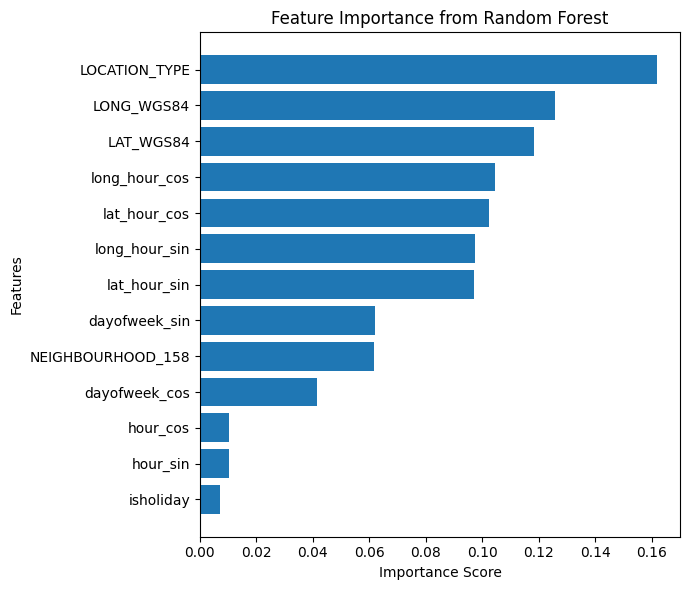

In [19]:
# Get importance scores from the RF model and sort them
importances = rf2.feature_importances_
feature_names = X_train2.columns
indices = np.argsort(importances)
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot results
plt.figure(figsize=(7, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

This seems to suggest that the location type, the GPS coordinates, and the interaction between time of day and location are important variables.

### Gradient Boosted Trees (xgboost)
We try a different algorithm to deal with the low performance on the minority classes. Gradient boosting may be a good algorithm to consider because of its sequential nature, where each subsequent model focuses more on the previous model's missclassifications. This is usually a good way to reduce bias, and in our case, it may help with the low performance on the minority classes. Here, I implement gradient boosted trees using the xgboost package.

We can first try with the one-hot-encoded data.

In [24]:
# Convert data into DMatrix type
dtrain1 = xgb.DMatrix(X_train1, label=y_train1)

In [27]:
# Set up model parameters
params = {
    'objective': 'multi:softmax',  # Multiclass classification objective
    'eta': 0.1,                    # Learning rate
    'num_class': 5,                # Number of target classes
    'max_depth': 5,                # Maximum depth of trees
    'subsample': 0.8,              # Subsample ratio for each tree
    'colsample_bytree': 0.8,       # Feature subsampling ratio for each tree
}

In [31]:
# Train model
num_boost_round = 1000  # Number of boosting rounds (iterations)
model = xgb.train(params, dtrain1, num_boost_round)

In [32]:
# Get predicted values
dtest1 = xgb.DMatrix(X_test1)
y_pred1 = model.predict(dtest1)

In [33]:
multi_performance(y_true=y_test1, y_pred=y_pred1, classes=classes)

(            Assault Auto Theft Break and Enter   Robbery Theft Over
 f1         0.760005   0.578162        0.545367   0.25717   0.039988
 precision  0.672116   0.601723        0.630847   0.63049   0.382857
 recall     0.874337   0.556377        0.480288  0.161528   0.021096,
 0.6550288442617008)